In [2]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans


%matplotlib inline


In [3]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [4]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [5]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'mode' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
celldyn = celldyn[meas_columns+mode_columns+alrt_columns]
celldyn_full = celldyn[celldyn[meas_columns].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged

In [6]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list)]

pre_transformer = ColumnTransformer(transformer_list,remainder = 'passthrough')


In [7]:
with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]

In [8]:
sample_df = celldyn_full.loc[samples,]
sample_df_index = sample_df.index

model_data = pre_transformer.fit_transform(sample_df[meas_columns])
model_data = StandardScaler().fit_transform(sample_df)


In [20]:
reduce_dim = 4
embedder_full = pacmap.PaCMAP(n_dims = reduce_dim,n_neighbors = 50,MN_ratio=1.5,FP_ratio = 2.0)
transformed_data = embedder_full.fit_transform(model_data) # final_columns

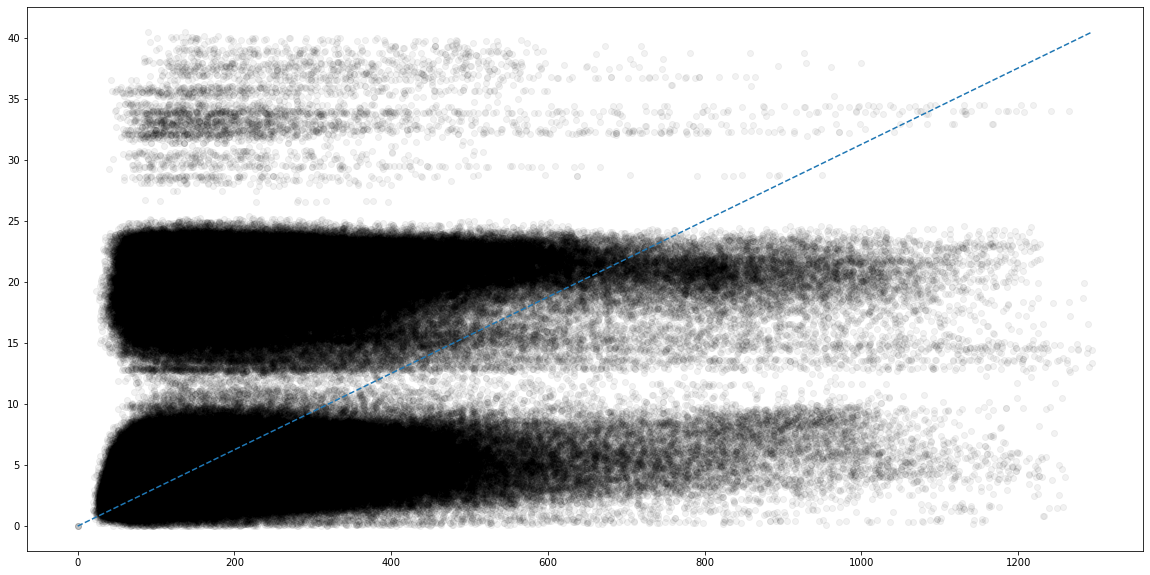

In [21]:
sample_selection = np.random.randint(0,250000,1000)
dist_before = distance.pdist(sample_df.reset_index(drop = True).loc[sample_selection,meas_columns])
dist_after = distance.pdist(transformed_data[sample_selection,:])


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [38]:
clusterer_embedding = KMeans(n_clusters = 2)
clusterer_embedding.fit(transformed_data)

KMeans(n_clusters=2)

In [39]:
clusterer_org_dat = KMeans(n_clusters = 2)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=2)

In [40]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

D:\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
D:\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [41]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [42]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [43]:
print("Distance preservation overall", dist_preservation_overall)
#print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.2583272481246957
Rand score 0.6475360557762231
Adjusted Rand score 8.662350429707395
Adjusted MI score 0.18129976309469792
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.0067351985938498135
David-Bouldin ratio, higher than 1 means better clustering for embedding 11.495242149768782


In [55]:
alrt_columns

['c_Alrt_rrbc',
 'c_Alrt_wbc',
 'c_Alrt_dif',
 'c_Alrt_wvf',
 'c_Alrt_fp',
 'c_Alrt_bnd',
 'c_Alrt_ig',
 'c_Alrt_blst',
 'c_Alrt_vlym',
 'c_AlrtQ_bnd',
 'c_AlrtQ_ig',
 'c_AlrtQ_blst',
 'c_AlrtQ_vlym',
 'c_AlrtQ_fp',
 'c_Alrt_wbc_pltcmp',
 'c_Alrt_pltcmp2',
 'c_Alrt_rbcDlta',
 'c_Alrt_pltDlta',
 'c_Alrt_rbc',
 'c_Alrt_plt',
 'c_Alrt_hb',
 'c_Alrt_rbc_assym',
 'c_Alrt_rbc_pltCmp2',
 'c_Alrt_lri',
 'c_Alrt_uri',
 'c_Alrt_optlri',
 'c_Alrt_opturi',
 'c_Alrt_retc',
 'c_Alrt_retcHI',
 'c_Alrt_retcIN']

In [44]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns+meas_columns])
plot_df['k_means']  = clusterer_embedding.labels_

plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))

In [48]:
mode_columns

['c_mode_cbc',
 'c_mode_rtc',
 'c_mode_cd61',
 'c_mode_xLyse',
 'c_mode_xCnt',
 'c_mode',
 'failmode']

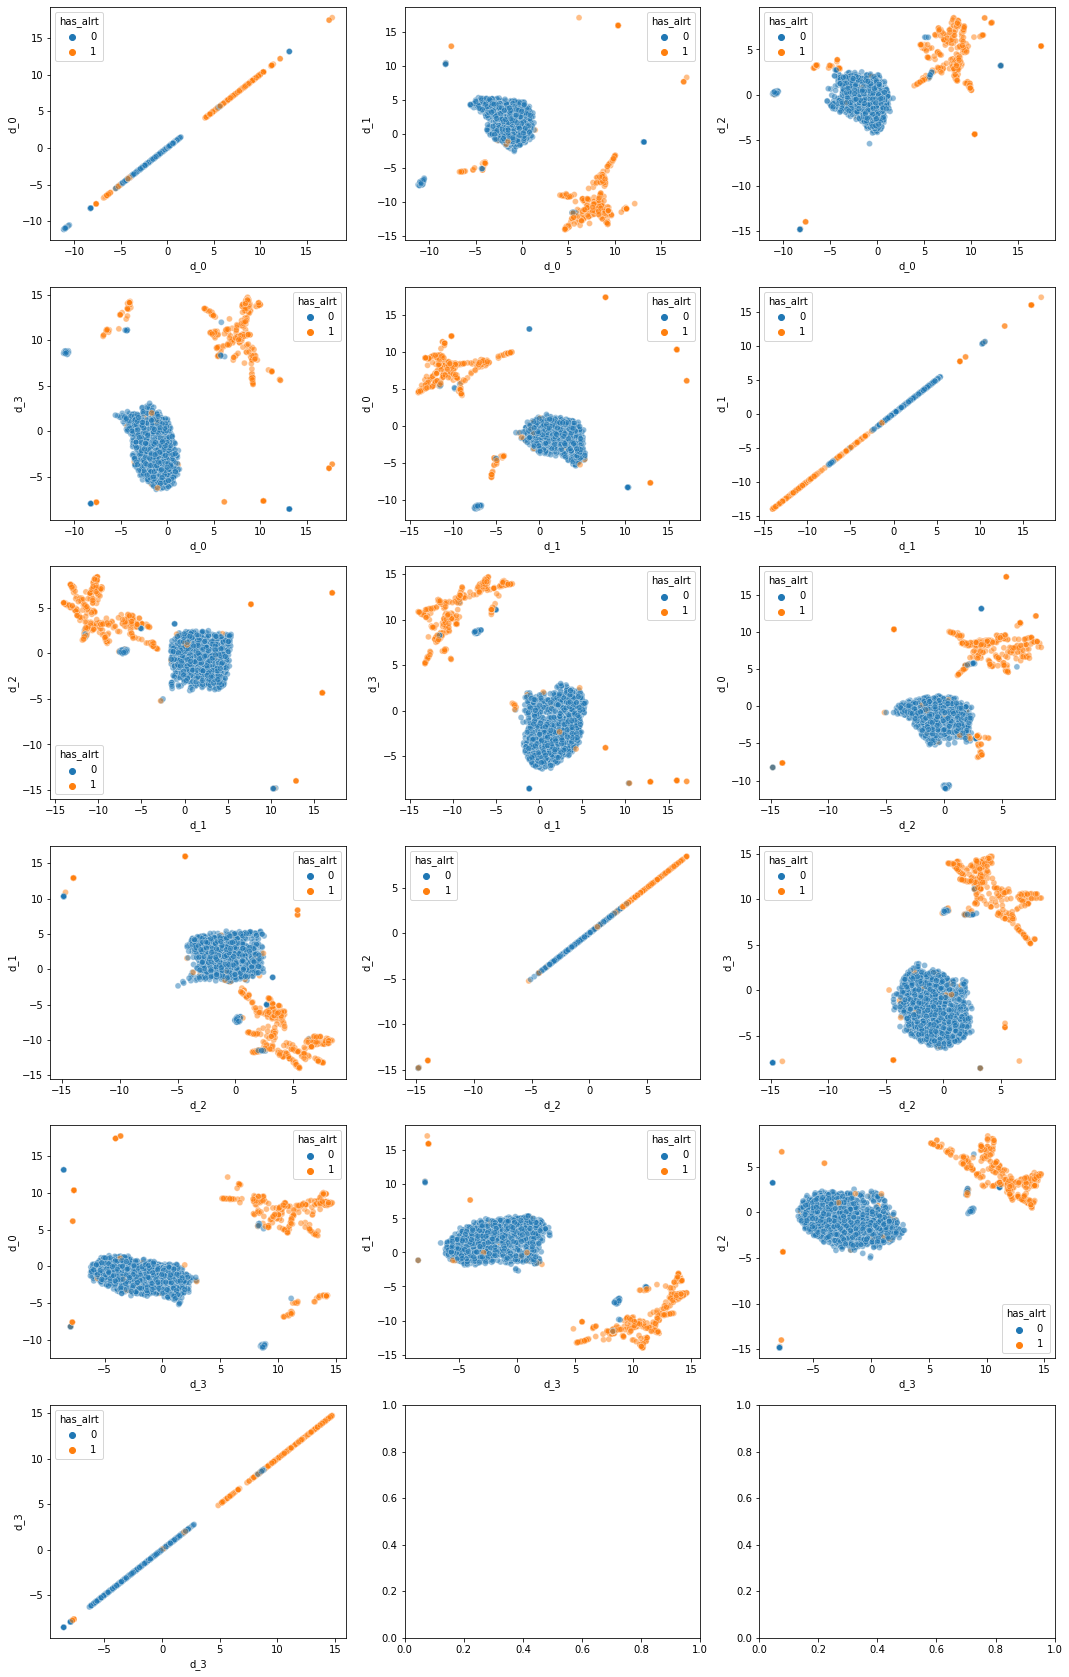

In [56]:
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
fig.patch.set_facecolor("white")

for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='has_alrt', alpha=0.5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='has_alrt', alpha=0.5)
        k += 1

In [93]:
pd.set_option('display.max_rows', 100)
plot_df.groupby("has_alrt")[meas_columns].mean().T

has_alrt,0,1
c_b_wbc,8.572003e+00,13.894425
c_b_wvf,9.927901e-01,0.968481
c_b_neu,5.854789e+00,8.584701
c_b_seg,5.854789e+00,7.438799
c_b_bnd,1.000000e-20,0.686327
c_b_ig,1.000000e-20,0.459574
c_b_lym,1.806230e+00,3.787206
c_b_lyme,1.806230e+00,3.458957
c_b_vlym,1.000000e-20,0.328048
c_b_mon,6.820407e-01,1.241104
